In [2]:
import os
import numpy as np
import tensorflow.keras as keras
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [3]:
model_name = r"model_test.h5"
model_path =  r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\models"
load_path = r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\data\processed"

model_path = os.path.join(model_path, model_name)

class MonteCarloDropout(keras.layers.Dropout):
    """Keeps dropout on in testing mode for uncertainty predictions"""
    def call(self, inputs):
        return super().call(inputs, training=True)

model = keras.models.load_model(model_path, custom_objects={"f1_score": f1_score, "MonteCarloDropout": MonteCarloDropout})

with open(os.path.join(load_path, "processed_data.pickle"), "rb") as handle:
    combined_data = pickle.load(handle)

y_test = combined_data['y_test']
y_train = combined_data['y_train']

event_X_test = combined_data['event_X_test']
object_X_test = combined_data['object_X_test']

In [3]:
def vary_test_data(event_data, object_data, percentage):
    varied_event_data = event_data.copy()
    varied_object_data = add_noise(object_data, percentage)
    varied_event_data[:] = add_noise(event_data.values, percentage)

    return [varied_event_data, varied_object_data]


def add_noise(data, percentage):
    varied_data = data.copy()
    for col in range(data.shape[1]):
        mean = np.mean(data[:, col])
        std = np.std(data[:, col]) * percentage
        noise = np.random.normal(mean, std, data[:, col].shape)
        varied_data[:, col] += noise

    return varied_data


def get_predictions(n_bins, max_percent):
    percentages = []
    scores = []
    
    for i in range(1, n_bins+1):
        percentage = np.round((i / n_bins) * (max_percent/100), 4)
        varied_test_data = vary_test_data(event_X_test, object_X_test, percentage)
        
        preds = model.predict(varied_test_data).ravel()
        auc = roc_auc_score(y_test, preds)
        scores.append(auc)
        percentages.append(percentage)
    
    return (percentages, scores)

In [ ]:
robust_df = pd.DataFrame(columns=['percentage', 'AUC'])
num_samples = 10
n_bins = 5
max_percent = 20

for _ in tqdm(range(num_samples)):
    percentages, scores = get_predictions(n_bins, max_percent)
    for percentage, score in zip(percentages, scores):
        robust_df = robust_df.append({'percentage': percentage*100, 'AUC': score}, ignore_index=True)

baseline_preds = model.predict([event_X_test, object_X_test]).ravel()
baseline_auc = roc_auc_score(y_test, baseline_preds)

robust_df['Δ ROC AUC'] = robust_df['AUC'] - baseline_auc

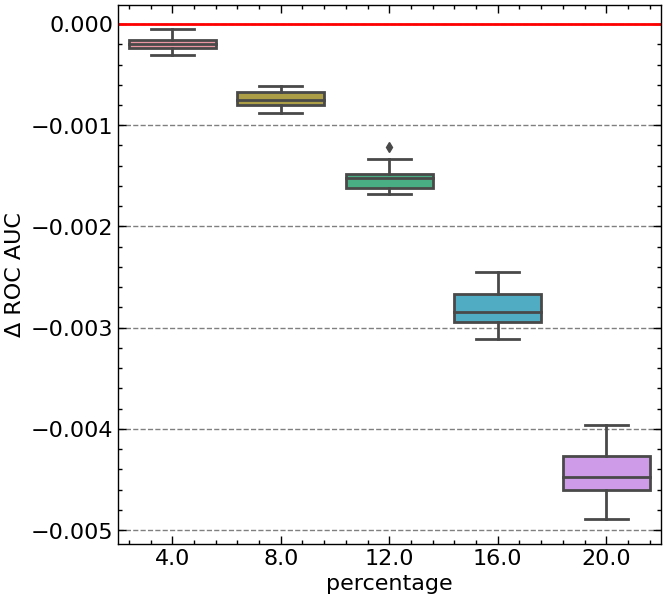

In [42]:
with plt.style.context(['science', 'grid', 'notebook', 'high-contrast']):
    plt.figure(figsize=(7, 7))
    sns.boxplot(x="Gaussian Noise (%)", y="Δ ROC AUC", data=robust_df)
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.show()